In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#fetching gold data from yahoo finance
data = yf.Ticker('GC=F')
symbol = 'GC=F'
start_date = "2010-01-01"
data = yf.download('GC=F', period = 'max')

# Resetting the index to turn the date index into a column
data.reset_index(inplace=True)

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
3,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
4,2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...,...,...
5916,2024-04-01,2235.699951,2264.199951,2230.000000,2236.500000,2236.500000,400
5917,2024-04-02,2252.000000,2279.199951,2247.600098,2261.000000,2261.000000,435
5918,2024-04-03,2281.699951,2298.800049,2267.899902,2294.399902,2294.399902,285
5919,2024-04-04,2301.699951,2302.899902,2280.000000,2288.800049,2288.800049,285


In [2]:
# trim dataset to relevent columns (we only need date and close to forecast prices)
data = data[['Date', 'Close']]
data

,Date,Close
0,2000-08-30,273.899994
1,2000-08-31,278.299988
2,2000-09-01,277.000000
3,2000-09-05,275.799988
4,2000-09-06,274.200012
...,...,...
5916,2024-04-01,2236.500000
5917,2024-04-02,2261.000000
5918,2024-04-03,2294.399902
5919,2024-04-04,2288.800049


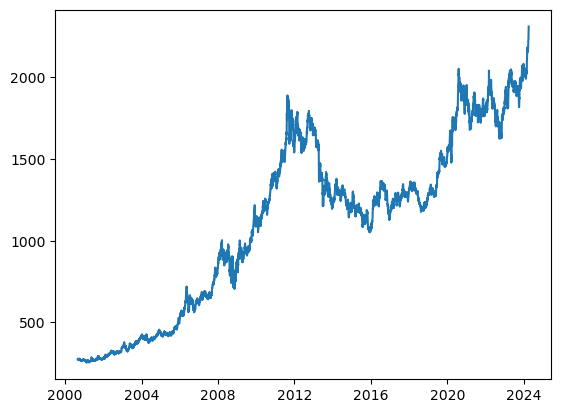

In [3]:
#simple transformations
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
#takes df from above and creates a lookback window of a week (lookback =7) 
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    #shifts dataframe for each lookback window
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

#any greater lookback doesn't capture the volatility of gold 
lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-09-11,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000,278.299988,273.899994
2000-09-12,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000,278.299988
2000-09-13,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000
2000-09-14,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988
2000-09-15,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012
...,...,...,...,...,...,...,...,...
2024-04-01,2236.500000,2217.399902,2190.600098,2175.600098,2174.800049,2158.100098,2182.399902,2157.899902
2024-04-02,2261.000000,2236.500000,2217.399902,2190.600098,2175.600098,2174.800049,2158.100098,2182.399902
2024-04-03,2294.399902,2261.000000,2236.500000,2217.399902,2190.600098,2175.600098,2174.800049,2158.100098


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 273.1000061 ,  273.29998779,  274.        , ...,  277.        ,
         278.29998779,  273.8999939 ],
       [ 272.8999939 ,  273.1000061 ,  273.29998779, ...,  275.79998779,
         277.        ,  278.29998779],
       [ 272.79998779,  272.8999939 ,  273.1000061 , ...,  274.20001221,
         275.79998779,  277.        ],
       ...,
       [2294.39990234, 2261.        , 2236.5       , ..., 2175.60009766,
        2174.80004883, 2158.10009766],
       [2288.80004883, 2294.39990234, 2261.        , ..., 2190.60009766,
        2175.60009766, 2174.80004883],
       [2310.30004883, 2288.80004883, 2294.39990234, ..., 2217.39990234,
        2190.60009766, 2175.60009766]])

In [7]:
shifted_df_as_np.shape

(5914, 8)

In [8]:
#runs scaler on data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.98248346, -0.98215076, -0.98146423, ..., -0.97767926,
        -0.97602689, -0.98049187],
       [-0.9826781 , -0.98234688, -0.98215076, ..., -0.97890233,
        -0.9773702 , -0.97592614],
       [-0.98277542, -0.98254304, -0.98234688, ..., -0.98053304,
        -0.9786102 , -0.97727509],
       ...,
       [ 0.98452691,  0.96724376,  0.9432159 , ...,  0.95739713,
         0.98367342,  0.97468102],
       [ 0.97907746,  1.        ,  0.96724376, ...,  0.97268531,
         0.98450013,  0.99201001],
       [ 1.        ,  0.99450806,  1.        , ...,  1.        ,
         1.        ,  0.9928402 ]])

In [9]:
#changes df into x and y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5914, 7), (5914,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.98049187, -0.97602689, -0.97767926, ..., -0.98095617,
        -0.98146423, -0.98215076],
       [-0.97592614, -0.9773702 , -0.97890233, ..., -0.9811556 ,
        -0.98215076, -0.98234688],
       [-0.97727509, -0.9786102 , -0.98053304, ..., -0.98185355,
        -0.98234688, -0.98254304],
       ...,
       [ 0.97468102,  0.98367342,  0.95739713, ...,  0.95652814,
         0.9432159 ,  0.96724376],
       [ 0.99201001,  0.98450013,  0.97268531, ...,  0.97557206,
         0.96724376,  1.        ],
       [ 0.9928402 ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  0.99450806]])

In [11]:
#use first 95% as train and last 5% as test
split_index = int(len(X) * 0.95)

split_index

5618

In [12]:
# splitting into train and test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5618, 7), (296, 7), (5618,), (296,))

In [13]:
#PyTorch requires an extra dimension at end
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5618, 7, 1), (296, 7, 1), (5618, 1), (296, 1))

In [14]:
#wrapping in tensors for PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5618, 7, 1]),
 torch.Size([296, 7, 1]),
 torch.Size([5618, 1]),
 torch.Size([296, 1]))

In [15]:
#need datasets object for PyTorch
#needs to be custom class
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
# wrap datasets in dataloaders to get batches
# used for iteration
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
#gives predicted outputs of arrays
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
#takes in number of features, dimensions and number of stacked layers (more layers = more complexity in model)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        #initally use 1 layer to prevent overfitting in training data
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        #maps hidden layer to 1. Needed to predict final closing value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #initialise LSTM with default h0 and c0
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        #output is gotten from passing varibles in fully connected layer
        out = self.fc(out[:, -1, :])
        return out

#initial model has 1 input size, 4 hidden sizes and 1 stacked layer
#model = LSTM(1, 4, 1) MAPE: 2.61
#Attempt 2:  Increase to 8 hidden units and 2 stacked layers
#model = LSTM(1, 8, 2)  MAPE: 2.89
#Attempt 3:  Increase to 16 hidden units and 4 stacked layers
#model = LSTM(1, 16, 4) MAPE: 3.10
#Attempt 4: Increase to 32 hidden unit and 8 stacked layers <----overfitted
#model = LSTM(1, 32, 8) MAPE: 1.87
#Attempt 5:  Increase to 24 hidden units and 6 stacked layers
#model = LSTM(1, 24, 6) MAPE: 2.98
#Attempt 6: 16 hidden units and 1 stacked layer
#model = LSTM(1, 16, 1) MAPE: 1.56
#Attempt 7: 12 hidden units and 1 stacked layer. MAPE of 1.079
model = LSTM(1,12,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

In [20]:
#sets model to training mode
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        #puts x and y batch onto device we're using 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        #comparing model's output to ground truth
        #loss is a tensor with a single value
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        #zero out gradients 
        optimizer.zero_grad()
        #backwards pass 
        loss.backward()
        optimizer.step()

        #every 100 batches get avg loss across batches and print
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
#sets model to validate mode
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        #don't need to calcualte gradient as there's no model updates
        with torch.no_grad():
            output = model(x_batch)
            #compare output to ground truth
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    #average loss value across all batches
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
#10 epochs is all that is necessary as any more will cause overfitting
num_epochs = 10
#trying to minimise mean squared error
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.130
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.016
***************************************************

Epoch: 2
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.008
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.005
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.001
*****************

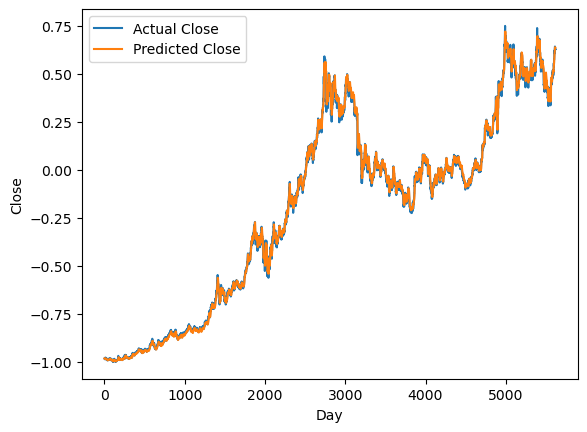

In [23]:
#no gradients for predictions
with torch.no_grad():
    #makes sure it on the device and is put to the CPU (numpy doesn't use GPU)
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
#above data still includes scalar begins at -1
#do opposite of earlier transform
train_predictions = predicted.flatten()

#lookback+1 is the length of the whole dataset
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

#return in right scale
train_predictions = dc(dummies[:, 0])
train_predictions

array([ 273.72917402,  273.3079596 ,  272.74629954, ..., 1937.60013218,
       1935.41076043, 1935.46802893])

In [25]:
#first column is no y_train.flatter()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 273.10001675,  272.89997512,  272.80001556, ..., 1922.90001221,
       1929.49997733, 1927.8000522 ])

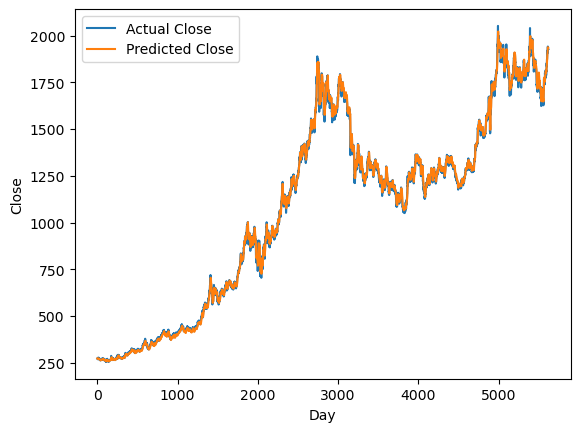

In [26]:
#same graph as earlier with different y_train and predictions
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
#convert to vector of predictions 
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1934.98531978, 1931.20265869, 1912.69893022, 1899.61972322,
       1891.51932337, 1887.54593061, 1881.76542569, 1877.09421471,
       1871.17847038, 1868.15659224, 1859.92818044, 1855.96887512,
       1852.76925025, 1848.6207445 , 1845.48818809, 1839.28371251,
       1831.9570193 , 1829.18620383, 1830.81948924, 1835.1145656 ,
       1837.51671893, 1843.69357088, 1848.59642836, 1841.95769216,
       1835.86377235, 1835.84233495, 1845.63984244, 1868.09999748,
       1883.75077458, 1901.46162523, 1912.54170216, 1934.41851473,
       1952.5420661 , 1953.08375875, 1954.4424616 , 1968.4567683 ,
       1975.23515389, 1971.45561653, 1973.14837544, 1972.71662606,
       1976.83217946, 1976.30083801, 1979.41324326, 1993.05074159,
       2003.50417248, 2008.34596397, 2005.3555682 , 2006.83052305,
       2009.50542144, 2019.40925847, 2015.51977785, 2010.29738051,
       2010.23098579, 2007.00679978, 2007.58518102, 2000.06383616,
       1996.79769408, 1996.63287104, 1994.32479731, 1993.63383

In [28]:
#make ground truth proper scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1916.3000471 , 1862.90001755, 1866.19996948, 1871.69995061,
       1877.40003463, 1866.19996948, 1862.80005798, 1851.89999402,
       1854.00000241, 1834.19992332, 1842.00001573, 1840.40005017,
       1832.99997978, 1832.00001662, 1817.99998111, 1808.80002603,
       1817.00001795, 1828.90004507, 1837.69997814, 1833.50002261,
       1847.69997725, 1847.90001888, 1813.9000464 , 1812.69998036,
       1829.30006708, 1862.00001395, 1911.69994706, 1906.19996592,
       1926.59998616, 1918.99999663, 1969.80003622, 1979.19997168,
       1937.99997045, 1946.80002601, 1993.80007083, 1982.09996285,
       1952.40002796, 1972.40002619, 1966.10000102, 1980.30007816,
       1968.99999219, 1983.90003129, 2022.19998011, 2020.90001575,
       2011.90004105, 1989.09994998, 2004.80003311, 2010.90001664,
       2041.30003599, 2002.19992064, 1994.19997035, 2007.40002308,
       1995.19993351, 2007.60000346, 1979.49997288, 1989.09994998,
       1993.99998997, 1985.69997723, 1989.89999401, 1990.09997

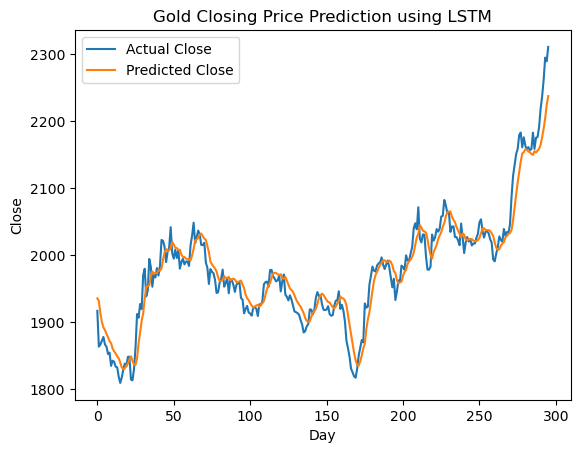

In [29]:
#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.title("Gold Closing Price Prediction using LSTM")
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [30]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


Root Mean Square Error (RMSE): 24.575348303325
Mean Absolute Error (MAE): 18.5674592267923
Mean Absolute Percentage Error (MAPE): 0.9347127543411373


In [31]:
#comparing the RMSE, MAE and MAPE for Training vs Validation data to check for overfitting
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    return rmse, mae, mape

# Assuming 'train_loader' and 'test_loader' are already defined
# Evaluate the model on training data
train_rmse, train_mae, train_mape = evaluate_model(model, train_loader)
print(f'Training - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, MAPE: {train_mape:.3f}%')

# Evaluate the model on test (validation) data
val_rmse, val_mae, val_mape = evaluate_model(model, test_loader)  # Use test_loader as validation loader
print(f'Validation - RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, MAPE: {val_mape:.3f}%')


Training - RMSE: 0.017, MAE: 0.012, MAPE: 1154.810%
Validation - RMSE: 0.024, MAE: 0.018, MAPE: 2.681%


The day before today for GC=F is: Date     2024-04-04 00:00:00
Close            2288.800049
Name: 5919, dtype: object
The current closing price for GC=F is: 2288.800048828125


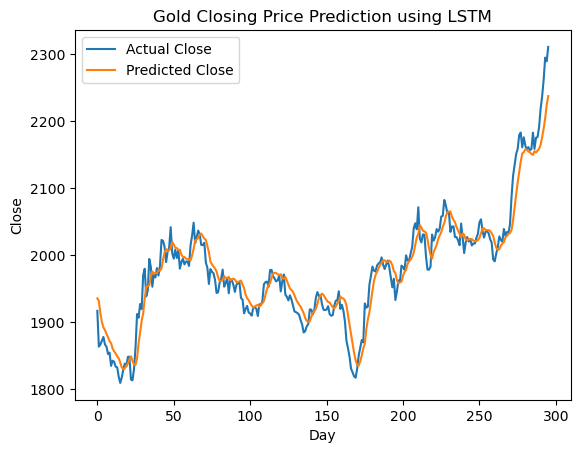

Root Mean Square Error (RMSE): 24.575348303325
Mean Absolute Error (MAE): 18.5674592267923
Mean Absolute Percentage Error (MAPE): 0.9347127543411373
Predicted Gold price for tomorrow: 2236.6041235862253


<Figure size 640x480 with 0 Axes>

In [32]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas_datareader as pdr
from datetime import datetime, timedelta
import yfinance as yf
import datetime as dt
# Get the last row of the dataframe, which corresponds to the most recent closing price
yesterday = data.iloc[-2]
print(f"The day before today for {symbol} is: {yesterday}")
current_price = yesterday['Close']
print(f"The current closing price for {symbol} is: {current_price}")

#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.title("Gold Closing Price Prediction using LSTM")
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
#plt.savefig(r'C:\Users\jackc\Documents\FYP_ML_Predict\static\images\LSTM_Gold_PNG.png')
plt.savefig(r'C:\Users\15105006\Desktop\ML_Project\static\images\LSTM_Gold_PNG.png')
plt.show()
plt.clf()

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)
# Correcting the approach to reshape and inverse transform the prediction
latest_input = shifted_df_as_np[-1, 1:].reshape(1, lookback, 1)  # Reshape for LSTM: [1, lookback, 1]

# Convert to PyTorch tensor
latest_input_tensor = torch.tensor(latest_input).float().to(device)

# Make the prediction
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    prediction_scaled = model(latest_input_tensor).cpu().numpy()

# Prepare the data for inverse transformation correctly
prediction_scaled_expanded = np.expand_dims(prediction_scaled.flatten(), axis=0)
dummy_features = np.zeros((1, lookback))
combined_prediction = np.concatenate((prediction_scaled_expanded, dummy_features), axis=1)

# Inverse transform the prediction to get it back into the original scale
next_day_price = scaler.inverse_transform(combined_prediction)[0, 0]

print(f'Predicted Gold price for tomorrow: {next_day_price}')
import pickle
model_info = {
    'current_price': current_price,
    'next_day_price': next_day_price,
    'rmse': rmse,
    'mae': mae,
    'mape': mape
}
#with open(r'C:\Users\jackc\Documents\FYP_ML_Predict\models\LSTM_Gold.pkl', 'wb') as pkl:
 #   pickle.dump(model_info, pkl)
    
with open(r'C:\Users\15105006\Desktop\ML_Project\models\LSTM_Gold.pkl', 'wb') as pkl:
    pickle.dump(model_info, pkl)



In [33]:
def predict_next_7_days(model, scaler, last_7_days, N=7):
    model.eval()  # Ensure the model is in evaluation mode
    current_input = last_7_days
    
    for _ in range(N):
        # Convert current input to tensor
        current_input_tensor = torch.tensor(current_input).float().to(device)
        
        with torch.no_grad():
            # Predict the next day
            predicted_price_scaled = model(current_input_tensor).cpu().numpy()
            # Assuming the output is 2D, we reshape it to fit our expected input shape for the next step
            next_day_price_scaled = predicted_price_scaled.reshape(1, 1, -1)  # Adjust this line if needed
            
            # Prepare for next day prediction by updating the input
            current_input = np.append(current_input[:, 1:, :], next_day_price_scaled, axis=1)
    
    # The last prediction is the day we're interested in, reverse scaling
    last_prediction_scaled = current_input[0, -1, :].reshape(1, -1)
    dummy_array = np.zeros((1, scaler.n_features_in_))
    dummy_array[:, 0] = last_prediction_scaled  # Use the first feature assuming it's the 'Close' price
    
    # Inverse transform to get the original scale
    last_prediction = scaler.inverse_transform(dummy_array)[:, 0]

    return last_prediction[0]

# Let's ensure that last_7_days_scaled is correctly shaped as (1, 7, 1) before prediction
last_7_days_scaled = last_7_days_scaled.reshape(1, -1, 1)

# Now, you can call your predict_next_N_days function again with this correctly shaped input
price_in_7_days = predict_next_7_days(model, scaler, last_7_days_scaled, N=7)
print(f'Predicted gold price in 7 days: {price_in_7_days}')




NameError: name 'last_7_days_scaled' is not defined

In [ ]:
import numpy as np
import torch

def predict_price_in_N_days(model, scaler, last_N_days_scaled, N=30):
    model.eval()  # Set the model to evaluation mode
    current_input = last_N_days_scaled  # Starting input

    with torch.no_grad():
        for _ in range(N):
            # Predict the next day
            current_input_tensor = torch.tensor(current_input).float().to(device)
            predicted_price_scaled = model(current_input_tensor).cpu().numpy()
            
            # Prepare the input for the next prediction
            next_input_scaled = np.append(current_input[:, :, :], predicted_price_scaled.reshape(1, 1, 1), axis=1)
            current_input = next_input_scaled

    # Last prediction is the price after N days
    predicted_price_scaled = predicted_price_scaled[0, 0]  # Extract the predicted price
    dummy_array = np.zeros((1, 8))  # Adjust the size based on your scaler's expected feature input
    dummy_array[:, 0] = predicted_price_scaled

    predicted_price = scaler.inverse_transform(dummy_array)[:, 0]

    return predicted_price.item()

# Assuming last_7_days_scaled is defined and shaped correctly as per your LSTM model's input requirements
# Predict the gold price exactly 30 days into the future
predicted_price_in_30_days = predict_price_in_N_days(model, scaler, last_7_days_scaled, N=30)

# Display the predicted price
print(f'Predicted gold price in 30 days: {predicted_price_in_30_days}')